### Setup imports

In [82]:
!uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

Using Python 3.12.8 environment at: C:\Users\jesse\Documents\TU Delft\MSE git\img_classification\.venv
Audited 2 packages in 6ms


In [83]:
import os
import time
import pickle
import torch
import numpy
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


### Load datasets

In [84]:
DATASET_PATH = os.path.join(os.getcwd(), "../training_data/EuroSAT_RGB")

BATCH_SIZE = 1500
TEST_SIZE = 0.2
EPOCHS = 20

skip_training = False

In [85]:
transform = transforms.Compose([
  transforms.ToTensor()
])

In [86]:
dataset_full = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split into training and validation set
train_idx, val_idx = train_test_split(
  range(len(dataset_full)),       # Size of the full dataset
  test_size=TEST_SIZE,            # Fraction used for validation (test)
  stratify=dataset_full.targets   # Ensure class distribution is preserved
)

# Create the training and validation set
dataset_train = Subset(dataset_full, train_idx)
dataset_val = Subset(dataset_full, val_idx)

# TODO: Investigate if the DataLoader should shuffle the data
loader_full = DataLoader(dataset_full, batch_size=BATCH_SIZE, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

# Show all the class labels
print(dataset_full.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Set Model

In [87]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Adjust to the amount of classes
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset_full.classes))

### Setup Training

In [88]:
# Set up loss function
loss = torch.nn.CrossEntropyLoss()

# Set up optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


### Model Training

In [89]:
# Track time
start_time = time.time()

if not(skip_training):
  # Holder for training loss
  train_loss_list = []
  # Holder for validation loss
  validation_loss_list = []

  for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    # Setup model to perform training
    model.train()

    loss_train = 0
    # Number of correct predictions for train split
    train_correct = 0
    # Number of total predictions for train split
    train_total = 0

    # Perform training in batches
    for inputs, labels in tqdm(loader_train, desc="Training - batch"):
      # Move data to device (CPU or GPU)
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      # Calculate the predictions (outputs) on the batch
      outputs = model(inputs)
      # Calculate the loss (error) between predictions and labels
      train_loss = loss(outputs, labels)
      # Back propagate the error and update the weights
      train_loss.backward()
      # Update the weights using the SGD optimizer
      optimizer.step()
      # Extract the predicted class
      predicted = torch.max(outputs, 1)[1]
      # Update the total and number of correct
      train_correct += (predicted == labels).sum().item()
      train_total += labels.size(0) 
      
    # Calculate the training accuracy
    train_acc = 100. * train_correct / train_total

    train_loss_list.append(train_loss)

    # Setup model to perform validation (inference)
    model.eval()

    # Number of correct predictions for validation split
    val_correct = 0
    # Number of total predictions for validation split
    val_total = 0

    # Validate model using the validation set, the gradients do not need to be calculated
    with torch.no_grad():
      for inputs, labels in tqdm(loader_val, desc="Validation - batch"):
        # Move data to device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Calculate the predictions (outputs) on the batch
        outputs = model(inputs)
        # Calculate the loss (error) between predictions and labels
        val_loss = loss(outputs, labels)
        # Extract the predicted class
        predicted = torch.max(outputs, 1)[1]
        # Update the total and number of correct
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

      # Calculate the validation accuracy
      val_acc = 100. * val_correct / val_total

      # Append validation loss values
      validation_loss_list.append(val_loss)

    # Print Epoch information
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Train accuracy: {train_acc:.2f}%")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_acc:.2f}%")

  # Saving the model
  torch.save(model.state_dict(), "model.pth")
  print("Model trained")
  # Save the training and validation loss
  torch.save((train_loss_list, validation_loss_list), "losses.pth")
  # with open('train_loss.pkl', 'wb') as f:
  #   pickle.dump((train_loss_list, validation_loss_list), f)
  print("Losses saved")
else:
  print("Skip training...")
  try:
    model.load_state_dict(torch.load("model.pth", weights_only=True, map_location=device))
    print("Model loaded")
  except FileNotFoundError:
    print("Model not found")

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1/20
Train loss: 2.3779
Train accuracy: 14.19%
Validation loss: 2.4127
Validation accuracy: 10.15%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2/20
Train loss: 2.1112
Train accuracy: 22.57%
Validation loss: 2.2237
Validation accuracy: 23.93%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3/20
Train loss: 1.9062
Train accuracy: 32.15%
Validation loss: 1.9163
Validation accuracy: 35.13%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4/20
Train loss: 1.7393
Train accuracy: 42.14%
Validation loss: 1.7133
Validation accuracy: 45.26%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5/20
Train loss: 1.5980
Train accuracy: 50.24%
Validation loss: 1.5746
Validation accuracy: 52.85%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 6/20
Train loss: 1.4746
Train accuracy: 56.64%
Validation loss: 1.4610
Validation accuracy: 58.22%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 7/20
Train loss: 1.3654
Train accuracy: 61.05%
Validation loss: 1.3627
Validation accuracy: 62.52%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 8/20
Train loss: 1.2673
Train accuracy: 64.98%
Validation loss: 1.2752
Validation accuracy: 66.17%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 9/20
Train loss: 1.1785
Train accuracy: 67.89%
Validation loss: 1.1972
Validation accuracy: 69.17%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10/20
Train loss: 1.0978
Train accuracy: 70.12%
Validation loss: 1.1264
Validation accuracy: 71.20%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11/20
Train loss: 1.0245
Train accuracy: 72.29%
Validation loss: 1.0625
Validation accuracy: 73.43%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12/20
Train loss: 0.9581
Train accuracy: 74.23%
Validation loss: 1.0043
Validation accuracy: 75.31%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13/20
Train loss: 0.8979
Train accuracy: 75.83%
Validation loss: 0.9511
Validation accuracy: 76.65%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14/20
Train loss: 0.8433
Train accuracy: 77.33%
Validation loss: 0.9024
Validation accuracy: 77.56%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15/20
Train loss: 0.7935
Train accuracy: 78.54%
Validation loss: 0.8580
Validation accuracy: 78.78%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16/20
Train loss: 0.7481
Train accuracy: 79.69%
Validation loss: 0.8173
Validation accuracy: 79.78%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17/20
Train loss: 0.7065
Train accuracy: 80.70%
Validation loss: 0.7804
Validation accuracy: 80.50%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18/20
Train loss: 0.6684
Train accuracy: 81.62%
Validation loss: 0.7467
Validation accuracy: 81.61%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19/20
Train loss: 0.6334
Train accuracy: 82.34%
Validation loss: 0.7156
Validation accuracy: 82.26%


Training - batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation - batch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20/20
Train loss: 0.6012
Train accuracy: 83.07%
Validation loss: 0.6871
Validation accuracy: 82.87%
Model trained
Losses saved
Elapsed time: 313.08 seconds


### Plot losses over training epochs

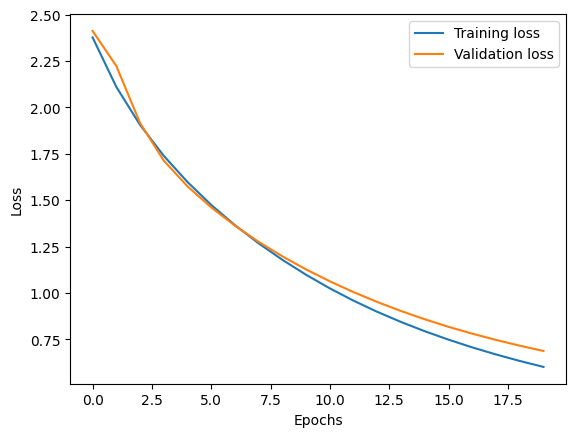

In [90]:
# Load losses from file if no training is performed
if skip_training:
  train_loss_list, validation_loss_list = torch.load('losses.pth', weights_only=True, map_location=device)

# Built a plot of the losses over the training epochs, move the data to the CPU for matplotlib
if torch.is_tensor(train_loss_list[0]):
  train_loss_list = [float(x.detach().cpu()) for x in train_loss_list]

if torch.is_tensor(validation_loss_list[0]):
  validation_loss_list = [float(x.detach().cpu()) for x in validation_loss_list]

plt.plot(train_loss_list, label='Training loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Measure on the test split

In [91]:
# Set model to evaluation mode
model.eval()

# Number of correct predictions for test split
test_correct = 0
# Number of total predictions for test split
test_total = 0

predictions = []
targets = []
images = []

# Evaluate model on the test set
with torch.no_grad():
  # Split into batches
  for inputs, labels in tqdm(loader_full, desc="Test - batch"):
    # Move data to device (CPU or GPU)
    inputs, labels = inputs.to(device), labels.to(device)

    # Calculate the predictions (outputs) on the batch
    outputs = model(inputs)
    predicted = torch.max(outputs, 1)[1]
    # Update the total and number of correct
    test_correct += (predicted == labels).sum().item()
    test_total += labels.size(0)
    # Store the predictions and targets
    predictions += list(predicted)
    targets += list(labels)
    images += list(inputs)

  # Calculate the test accuracy
  test_accuracy = test_correct / test_total

print(f"Test accuracy: {test_accuracy:.4f}%")

# Move predictions, targets and images to the CPU for matplotlib
predictions = [x.detach().cpu().numpy() for x in predictions]
targets = [x.detach().cpu().numpy() for x in targets]
images = [x.detach().cpu().numpy() for x in images]


Test - batch:   0%|          | 0/18 [00:00<?, ?it/s]

Test accuracy: 0.8357%


### Show predictions on random images

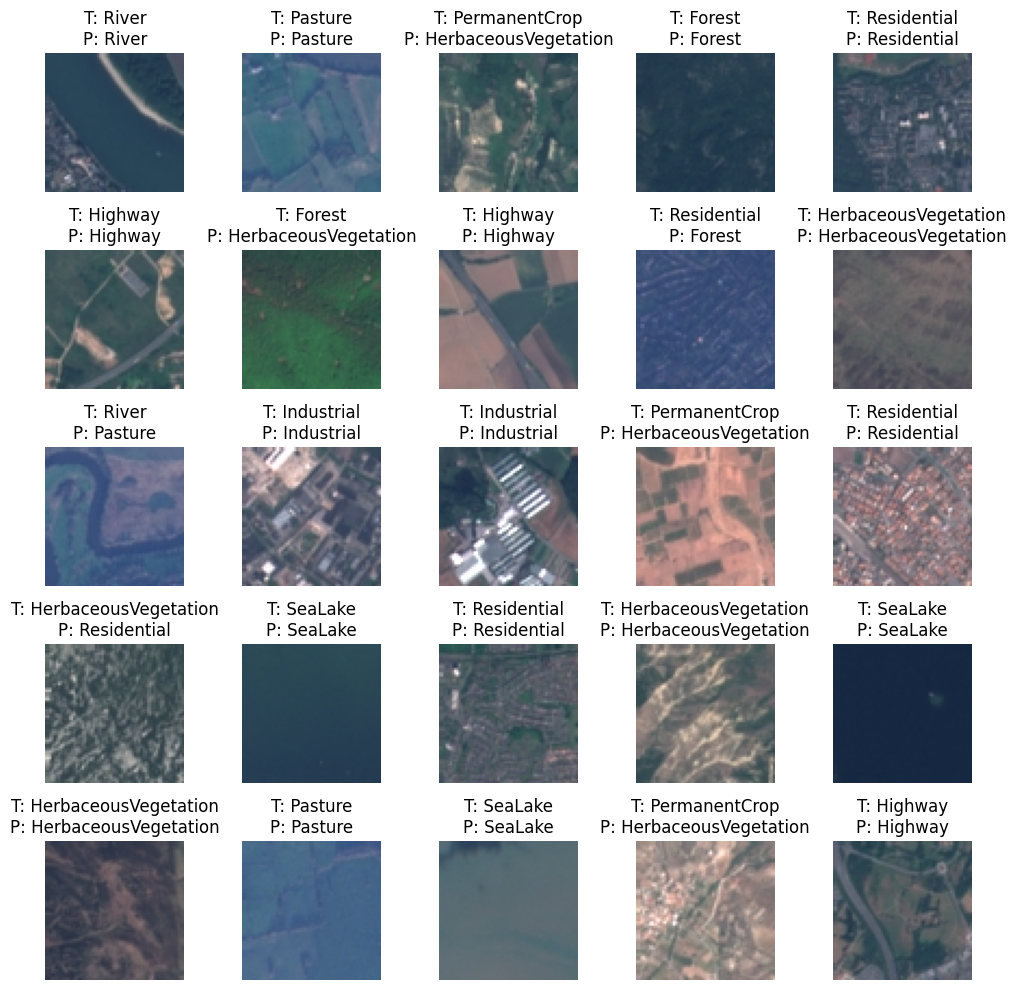

In [92]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
  ax = axes[i // 5, i % 5]
  ax.imshow(numpy.moveaxis(images[i], 0, -1))
  ax.set_title(f"T: {dataset_full.classes[targets[i]]}\nP: {dataset_full.classes[predictions[i]]}")
  ax.axis('off')
plt.tight_layout()